## HILL CLIMBING

Hill Climbing is a heuristic search used for optimization problems.
Given a large set of inputs and a good heuristic function, it tries to find a sufficiently good solution to the problem. 
This solution may or may not be the global optimum.
The algorithm is a variant of generate and test algorithm. 
<br>
As a whole, the algorithm works as follows:
- Evaluate the initial state.
- If it is equal to the goal state, return.
- Find a neighboring state (one which is heuristically similar to the current state)
- Evaluate this state. If it is closer to the goal state than before, replace the initial state with this state and repeat these steps.
<br>

In [1]:
from search import *
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

In [2]:
psource(hill_climbing)

## SIMULATED ANNEALING

The intuition behind Hill Climbing was developed from the metaphor of climbing up the graph of a function to find its peak. 
There is a fundamental problem in the implementation of the algorithm however.
To find the highest hill, we take one step at a time, always uphill, hoping to find the highest point, 
but if we are unlucky to start from the shoulder of the second-highest hill, there is no way we can find the highest one. 
The algorithm will always converge to the local optimum.
Hill Climbing is also bad at dealing with functions that flatline in certain regions.
If all neighboring states have the same value, we cannot find the global optimum using this algorithm.
<br>
<br>
Let's now look at an algorithm that can deal with these situations.
<br>
Simulated Annealing is quite similar to Hill Climbing, 
but instead of picking the _best_ move every iteration, it picks a _random_ move. 
If this random move brings us closer to the global optimum, it will be accepted, 
but if it doesn't, the algorithm may accept or reject the move based on a probability dictated by the _temperature_. 
When the `temperature` is high, the algorithm is more likely to accept a random move even if it is bad.
At low temperatures, only good moves are accepted, with the occasional exception.
This allows exploration of the state space and prevents the algorithm from getting stuck at the local optimum.


In [3]:
psource(simulated_annealing)

The temperature is gradually decreased over the course of the iteration.
This is done by a scheduling routine.
The current implementation uses exponential decay of temperature, but we can use a different scheduling routine instead.

In [4]:
psource(exp_schedule)

Next, we'll define a peak-finding problem and try to solve it using Simulated Annealing.
Let's define the grid and the initial state first.

In [5]:
initial = (0, 0)
grid = [[3, 7, 2, 8], [5, 2, 9, 1], [5, 3, 3, 1]]

We want to allow only four directions, namely `N`, `S`, `E` and `W`.
Let's use the predefined `directions4` dictionary.

In [6]:
directions4

{'W': (-1, 0), 'N': (0, 1), 'E': (1, 0), 'S': (0, -1)}

In [7]:
directions8

{'W': (-1, 0),
 'N': (0, 1),
 'E': (1, 0),
 'S': (0, -1),
 'NW': (-1, 1),
 'NE': (1, 1),
 'SE': (1, -1),
 'SW': (-1, -1)}

Define a problem with these parameters.

In [8]:
psource(PeakFindingProblem)

Let's find the peak of a two-dimensional gaussian distribution.
We'll use the `gaussian_kernel` function from notebook.py to get the distribution.

In [9]:
initial = (0, 0)
grid = gaussian_kernel()

Let's use the `heatmap` function from notebook.py to plot this.

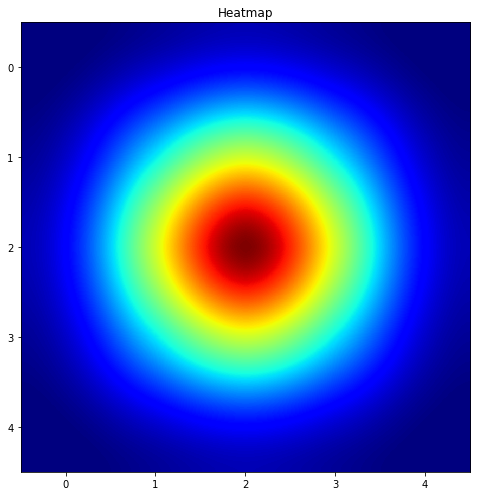

In [10]:
heatmap(grid, cmap='jet', interpolation='spline16')

In [11]:
problem = PeakFindingProblem(initial, grid, directions8)

In [12]:
%%timeit
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}

333 ms ± 6.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
max(solutions)

1.0

The peak is at 1.0 which is how gaussian distributions are defined.
<br>
This could also be solved by Hill Climbing as follows.

In [14]:
%%timeit
solution = problem.value(hill_climbing(problem))

118 µs ± 3.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
solution = problem.value(hill_climbing(problem))
solution

1.0

Let's define a 2D surface as a matrix.

In [16]:
grid = [[0, 0, 0, 1, 4], 
        [0, 0, 2, 8, 10], 
        [0, 0, 2, 4, 12], 
        [0, 2, 4, 8, 16], 
        [1, 4, 8, 16, 32]]

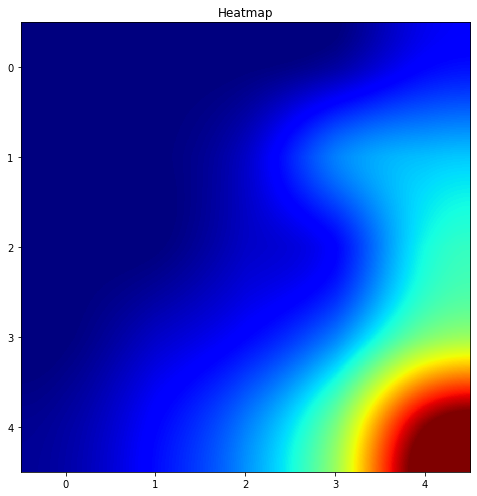

In [17]:
heatmap(grid, cmap='jet', interpolation='spline16')

The peak value is 32 at the lower right corner.
<br>
The region at the upper left corner is planar.

In [18]:
problem = PeakFindingProblem(initial, grid, directions8)

Solution by Hill Climbing

In [19]:
solution = problem.value(hill_climbing(problem))

In [20]:
solution

0

Solution by Simulated Annealing

In [21]:
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
max(solutions)

32

Notice that even though both algorithms started at the same initial state, 
Hill Climbing could never escape from the planar region and gave a locally optimum solution of **0**,
whereas Simulated Annealing could reach the peak at **32**.
<br>
A very similar situation arises when there are two peaks of different heights.
One should carefully consider the possible search space before choosing the algorithm for the task.

## GENETIC ALGORITHM

Genetic algorithms (or GA) are inspired by natural evolution and are particularly useful in optimization and search problems with large state spaces.

Given a problem, algorithms in the domain make use of a *population* of solutions (also called *states*), where each solution/state represents a feasible solution. At each iteration (often called *generation*), the population gets updated using methods inspired by biology and evolution, like *crossover*, *mutation* and *natural selection*.

### Overview

A genetic algorithm works in the following way:

1) Initialize random population.

2) Calculate population fitness.

3) Select individuals for mating.

4) Mate selected individuals to produce new population.

     * Random chance to mutate individuals.

5) Repeat from step 2) until an individual is fit enough or the maximum number of iterations is reached.

### Glossary

Before we continue, we will lay the basic terminology of the algorithm.

* Individual/State: A list of elements (called *genes*) that represent possible solutions.

* Population: The list of all the individuals/states.

* Gene pool: The alphabet of possible values for an individual's genes.

* Generation/Iteration: The number of times the population will be updated.

* Fitness: An individual's score, calculated by a function specific to the problem.

### Crossover

Two individuals/states can "mate" and produce one child. This offspring bears characteristics from both of its parents. There are many ways we can implement this crossover. Here we will take a look at the most common ones. Most other methods are variations of those below.

* Point Crossover: The crossover occurs around one (or more) point. The parents get "split" at the chosen point or points and then get merged. In the example below we see two parents get split and merged at the 3rd digit, producing the following offspring after the crossover.

![point crossover](images/point_crossover.png)

* Uniform Crossover: This type of crossover chooses randomly the genes to get merged. Here the genes 1, 2 and 5 were chosen from the first parent, so the genes 3, 4 were added by the second parent.

![uniform crossover](images/uniform_crossover.png)

### Mutation

When an offspring is produced, there is a chance it will mutate, having one (or more, depending on the implementation) of its genes altered.

For example, let's say the new individual to undergo mutation is "abcde". Randomly we pick to change its third gene to 'z'. The individual now becomes "abzde" and is added to the population.

### Selection

At each iteration, the fittest individuals are picked randomly to mate and produce offsprings. We measure an individual's fitness with a *fitness function*. That function depends on the given problem and it is used to score an individual. Usually the higher the better.

The selection process is this:

1) Individuals are scored by the fitness function.

2) Individuals are picked randomly, according to their score (higher score means higher chance to get picked). Usually the formula to calculate the chance to pick an individual is the following (for population *P* and individual *i*):

$$ chance(i) = \dfrac{fitness(i)}{\sum_{k \, in \, P}{fitness(k)}} $$

### Implementation

Below we look over the implementation of the algorithm in the `search` module.

First the implementation of the main core of the algorithm:

In [22]:
psource(genetic_algorithm)

The algorithm takes the following input:

* `population`: The initial population.

* `fitness_fn`: The problem's fitness function.

* `gene_pool`: The gene pool of the states/individuals. By default 0 and 1.

* `f_thres`: The fitness threshold. If an individual reaches that score, iteration stops. By default 'None', which means the algorithm will not halt until the generations are ran.

* `ngen`: The number of iterations/generations.

* `pmut`: The probability of mutation.

The algorithm gives as output the state with the largest score.

For each generation, the algorithm updates the population. First it calculates the fitnesses of the individuals, then it selects the most fit ones and finally crosses them over to produce offsprings. There is a chance that the offspring will be mutated, given by `pmut`. If at the end of the generation an individual meets the fitness threshold, the algorithm halts and returns that individual.

The function of mating is accomplished by the method `recombine`:

In [23]:
psource(recombine)

The method picks at random a point and merges the parents (`x` and `y`) around it.

The mutation is done in the method `mutate`:

In [24]:
psource(mutate)

We pick a gene in `x` to mutate and a gene from the gene pool to replace it with.

To help initializing the population we have the helper function `init_population`:

In [25]:
psource(init_population)

The function takes as input the number of individuals in the population, the gene pool and the length of each individual/state. It creates individuals with random genes and returns the population when done.

#### Eight Queens

Let's take a look at a more complicated problem.

In the *Eight Queens* problem, we are tasked with placing eight queens on an 8x8 chessboard without any queen threatening the others (aka queens should not be in the same row, column or diagonal). In its general form the problem is defined as placing *N* queens in an NxN chessboard without any conflicts.

First we need to think about the representation of each solution. We can go the naive route of representing the whole chessboard with the queens' placements on it. That is definitely one way to go about it, but for the purpose of this tutorial we will do something different. We have eight queens, so we will have a gene for each of them. The gene pool will be numbers from 0 to 7, for the different columns. The *position* of the gene in the state will denote the row the particular queen is placed in.

For example, we can have the state "03304577". Here the first gene with a value of 0 means "the queen at row 0 is placed at column 0", for the second gene "the queen at row 1 is placed at column 3" and so forth.

We now need to think about the fitness function. On the graph coloring problem we counted the valid edges. The same thought process can be applied here. Instead of edges though, we have positioning between queens. If two queens are not threatening each other, we say they are at a "non-attacking" positioning. We can, therefore, count how many such positionings are there.

Let's dive right in and initialize our population:

In [26]:
population = init_population(100, range(8), 8)
print(population[:5])

[[0, 2, 1, 2, 7, 2, 4, 5], [1, 6, 7, 0, 1, 3, 6, 0], [5, 1, 7, 6, 1, 4, 6, 6], [6, 4, 3, 7, 4, 1, 4, 4], [7, 7, 2, 3, 1, 4, 2, 4]]


We have a population of 100 and each individual has 8 genes. The gene pool is the integers from 0 to 7, in string form. Above you can see the first five individuals.

Next we need to write our fitness function. Remember, queens threaten each other if they are at the same row, column or diagonal.

Since positionings are mutual, we must take care not to count them twice. Therefore for each queen, we will only check for conflicts for the queens after her.

A gene's value in an individual `q` denotes the queen's column, and the position of the gene denotes its row. We can check if the aforementioned values between two genes are the same. We also need to check for diagonals. A queen *a* is in the diagonal of another queen, *b*, if the difference of the rows between them is equal to either their difference in columns (for the diagonal on the right of *a*) or equal to the negative difference of their columns (for the left diagonal of *a*). Below is given the fitness function.

In [27]:
def fitness(q):
    non_attacking = 0
    for row1 in range(len(q)):
        for row2 in range(row1+1, len(q)):
            col1 = int(q[row1])
            col2 = int(q[row2])
            row_diff = row1 - row2
            col_diff = col1 - col2

            if col1 != col2 and row_diff != col_diff and row_diff != -col_diff:
                non_attacking += 1

    return non_attacking

Note that the best score achievable is 28. That is because for each queen we only check for the queens after her. For the first queen we check 7 other queens, for the second queen 6 others and so on. In short, the number of checks we make is the sum 7+6+5+...+1. Which is equal to 7\*(7+1)/2 = 28.

Because it is very hard and will take long to find a perfect solution, we will set the fitness threshold at 25. If we find an individual with a score greater or equal to that, we will halt. Let's see how the genetic algorithm will fare.

In [28]:
solution = genetic_algorithm(population, fitness, f_thres=28, gene_pool=range(8))
print(solution)
print(fitness(solution))

[4, 0, 7, 5, 2, 6, 1, 3]
28


Figure(504x504)


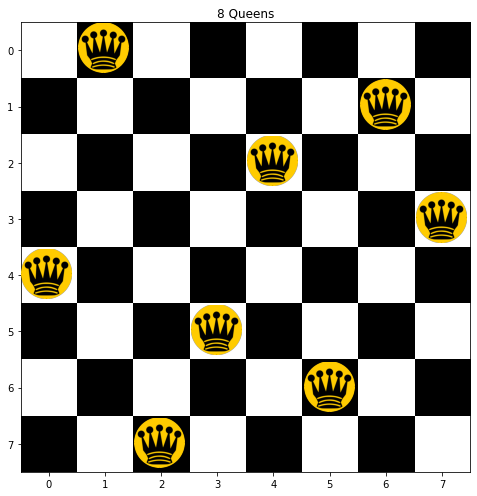

In [29]:
plot_NQueens(solution)